# Numerical Solution for the Bingham Model

This is set up for the early time, small Bingham number case.

## Import the necessary libraries and define all of the functions.

In [2]:
# Import the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sp
from scipy.special import erf
from scipy.special import erfc
from scipy.optimize import root
from decimal import *

# Use LaTeX font for plots.
plt.rcParams['text.usetex'] = True

In [3]:
# Define the system of ODEs. Technically, q is the negative of the flux. For the ODE method, not ODEint.
def semidiscODEs4(t,h, dx,B,eps):
    
    # Write vectors of h, one with h_0, one with h_N.
    hl = np.append(np.array([0]),h) # Just need to have something at the start so the indices are shifted by one. Since we overwrite q[0], it does not matter what it is.
    hu = np.append(h,np.array([1])) # last point is set to be 1.
    
    # Compute the height of the yield surface.
    Y = np.maximum(hl - (B*dx)/(3*abs(hu-hl)+eps*dx*np.ones(len(hu))), np.zeros(hu.shape))
    #Y = np.maximum((hu+hl)/2 - (B*dx)/(3*abs(hu-hl)+eps*dx*np.ones(len(hu))), np.zeros(hu.shape)) #alternative
    
    # Do a second pass where we don't use epsilon on those where the derivative is non-zero and large enough (which is when Y>0)
    Y[Y>0] = hl[Y>0] - (B*dx)/(3*abs(hu[Y>0]-hl[Y>0]))
    
    # Compute the respective fluxes.
    q = 0.5*(Y**2)*(3*hl-Y)*(hu-hl)/dx + (hu+hl)/2
    q[0] = 0 # set flux at the wall to be 0 due to BC. We do this so we don't have to solve an implicit equation at each time step. Newtonian case gave a cubic, which is easier.
    
    # Compute dh_i/dt for each interior i.
    dh = (q[1:]-q[:-1])/dx
    
    return dh

In [4]:
# Define the implicit equation for h0
# I tried multiplying though by ((h[:,0]-y)/dx)**2, but this made the tolerance required too small for the root finder.
def h0_eqn(y, h,t,dx,B):
    # Find the height of the yield surface at x=0.
    Y = y + (B*dx)/(3*(h[:,0]-y))
    
    # Define the implicit equation for h0.
    return (h[:,0]+y + (Y**2)*(3*y-Y)*(h[:,0]-y)/dx)

In [5]:
# Compute the yield surface from the numerical results. We do two passes, where the first allows us to find the points where we can safely set epsilon equal to 0.
def YS(h,t,dx,B,eps):
    hl = h[:,:-1]
    hu = h[:,1:]
    
    Y = np.maximum(hl - (B*dx)/(3*abs(hu-hl)+eps*dx*np.ones(hl.shape)), np.zeros(hl.shape))
    
    Y[Y>0] = hl[Y>0] - (B*dx)/(3*abs(hu[Y>0]-hl[Y>0]))
    
    return Y

In [6]:
# Function for the analytical height of the interface minus 1 at early time.
def z(x,t):
    # Set up arrays for z and xi. This also accounts for the initial condition.
    z = np.zeros(t.shape)
    xi = np.zeros(t.shape)
    
    # Find the indices where t=0 so we can ignore these to avoid division by 0.
    mask = (t!=0)
    
    # Compute xi where it is defined.
    xi[mask] = x[mask]/(2*np.sqrt(t[mask]))
    
    # Compute z where it is defined
    z[mask] = (2*np.sqrt(t[mask]))*(np.exp(-xi[mask]**2)/np.sqrt(np.pi) - xi[mask]*erfc(xi[mask]))
    
    return z

# Define the yield surface height.
def Y(x,t):
    # Set up arrays for z and xi. This also accounts for the initial condition.
    y = np.zeros(t.shape)
    xi = np.zeros(t.shape)
    Z = z(x,t)
    
    # Find the indices where t=0 so we can ignore these to avoid division by 0.
    mask = (t!=0)
    
    # Compute xi where it is defined.
    xi[mask] = x[mask]/(2*np.sqrt(t[mask]))
    print(np.max(xi[mask]))
    
    y[mask] = 1 + Z[mask] - B/(3*erfc(xi[mask]))
    
    return y

In [7]:
#Define the interface height
#Define the function for the height of the interface minus 1.
def z2(x,t):
    xi = x/(2*np.sqrt(t))
    
    return (2*np.sqrt(t))*(np.exp(-xi**2)/np.sqrt(np.pi) - xi*erfc(xi))

    
#Define the yield surface height.
def Y2(x,t):
    xi = x/(2*np.sqrt(t))
    
    erfcxi = erfc(xi)
    erfcxi[erfcxi==0] = np.nan # prevent division by zero
    
    return 1 + z2(x,t) - B/(3*erfcxi)

In [8]:
# Function that computes the L2 error in the solution at each time.
def L2error(num, an, N):
    d = (an-num)**2
    c = np.sqrt(np.sum(d, axis=1)/(N+1))
    return c

In [9]:
# Function that computes the experimental order of convergence.
def EOCs(N,err):
    EOCs = np.zeros(len(err)-1)
    for i in range(len(EOCs)):
        EOCs[i] = np.log(err[i+1]/err[i])/np.log(N[i]/N[i+1])
    return EOCs

## Choose the Relevant Parameters

In [10]:
# Define the parameters of the system, the time array, and the space grid.
N = 2**10
XN = 2
dx = XN/N
y_init0 = np.zeros(N-1)
y_init1 = np.ones(N-1)
x = np.linspace(0,XN,N+1)

# Choose the time interval and step.
t_start = 0
t_step = 0.0001
t_end = 0.03
t = np.arange(t_start,t_end+t_step,t_step)

B = 0.001
eps = 10**(-7) # B=0.001 needs eps at most 10^(-3) 

# Set up a meshgrid of x and t for the analytical solution.
x2, t2 = np.meshgrid(x, t)

## Solve the IVP

In [11]:
# Solve the IVP.
r = sp.ode(semidiscODEs4).set_integrator('vode', method='bdf', nsteps=20000) # nsteps may need to be increased if B or t_step is.

r.set_f_params(dx,B,eps)
r.set_initial_value(y_init1, t_start)

ts = np.array([0])
ys = np.array([y_init1])

while r.successful() and r.t < t_end-0.5*t_step:
    r.integrate(r.t + t_step)
    ts = np.append(ts,np.array([r.t]))
    ys = np.concatenate((ys,np.array([r.y])))

In [12]:
# Check that it got to the end time.
print(ys.shape)
print(ts[-1])

(301, 1023)
0.029999999999999874


In [13]:
# Use the boundary value to find the value at x_N
yN = np.array([np.ones(len(t))]).T

# Solve the implicit equation for x_0.
sols = root(h0_eqn, ys[:,0]+B*dx/3, args=(ys,t,dx,B))

sol = sols.x

# Fix the initial condition and make the shape of y0 correct for concatenation.
sol[0] = 1 
y0 = np.array([sol]).T

In [14]:
# Check that the root finder converged. If not, we do not want to append y0.
print(sols.message)

The solution converged.


In [15]:
# Glue x_0, x_N parts to the rest of the solution.
y_num2 = np.concatenate((y0,ys,yN), axis=1) # this one if the above converged.
# y_num2 = np.concatenate((ys,yN), axis=1) # this one if not. In this case, for plotting, x needs to be changed to x[1,] in "ax.plot(x, y_num2[t_index,:], ..." lines.

## Plot the Results and Compare with Asymptotics

In [16]:
# Compute the analytic solution.
y_an = np.ones(x2.shape) + z(x2, t2)

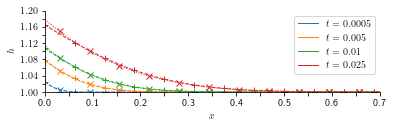

In [17]:
# Pick some time points to plot.
t_arr = np.array([0.0005, 0.005, 0.01, 0.025]) # may need to change this if you change the time interval

# Set up the plot.
fig = plt.figure(figsize=(6,1.5))
ax = fig.add_subplot(111)
cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Plot for a few different times.
for i in range(len(t_arr)):
    # Find the index for the specified time
    t_index = int(np.round(t_arr[i]/t_step))
    
    # Do the plotting.
    ax.plot(x, y_num2[t_index,:], '--' , marker='+', markevery=32, linewidth=1, color=cols[i])
    ax.plot(x, y_an[t_index,:], ':', marker='x', markevery=(16,32), linewidth=1, color=cols[i])
    ax.plot([0,1],[10,10], color=cols[i], linewidth=1, label=r'$t=s1$'.replace('s1',str(t_arr[i])))

    
# Add details to the plot.
ticks1 = np.arange(0,0.75,0.05)
ax.set_xticks(ticks1, labels=np.round(ticks1,1))
ax.set_xlim(0,0.7)
ax.set_xlabel(r'$x$')
xticks = ax.xaxis.get_major_ticks()
for i in range(len(ticks1)):
    xticks[i].label1.set_visible((i+1)%2)

ticks2 = np.arange(1,1.22,0.02)
ax.set_yticks(ticks2)
ax.set_ylim(1,1.2)
ax.set_ylabel(r'$h$')
yticks = ax.yaxis.get_major_ticks()
for i in range(len(ticks2)):
    yticks[i].label1.set_visible((i+1)%2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.legend()
#plt.savefig('Bingham_SmallT_NumAn2', bbox_inches='tight', dpi=500)
plt.show()

In [18]:
# Check mass conservation of the two solutions.
area_num = dx*np.sum(y_num2, axis=1)-0.5*dx*(y_num2[:,0]+y_num2[:,-1])
#print((area_num-XN)/t)

area_an = dx*np.sum(y_an, axis=1)-0.5*dx*(y_an[:,0]+y_an[:,-1])
#print((area_an-XN)/t)

## Plot Gradients

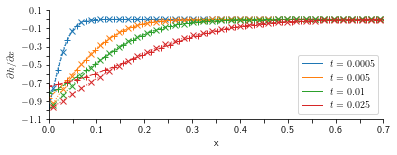

In [19]:
# Pick some time points to plot.
t_arr = np.array([0.0005, 0.005, 0.01, 0.025])

# Set up the plot.
fig = plt.figure(figsize=(6,2))
ax = fig.add_subplot(111)
cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Plot for a few different times.
for i in range(len(t_arr)):
    # Find the index for the specified time
    t_index = int(np.round(t_arr[i]/t_step))
    
    # Find/approximate gradients.
    dz_num2 = np.gradient(y_num2[t_index,:], dx, edge_order=2)
    dz_an = -erfc(x/(2*np.sqrt(t_arr[i])))
    
    # Do the plotting.
    ax.plot(x, dz_num2, '--' , marker='+', markevery=10, linewidth=1, color=cols[i])
    ax.plot(x, dz_an, ':', marker='x', markevery=(5,10), linewidth=1, color=cols[i])
    ax.plot([0,1],[10,10], color=cols[i], linewidth=1, label=r'$t=s1$'.replace('s1',str(t_arr[i])))

    
# Add details to the plot.
ticks1 = np.arange(0,0.75,0.05)
ax.set_xticks(ticks1, labels=np.round(ticks1,1))
ax.set_xlim(0,0.7)
ax.set_xlabel('x')
xticks = ax.xaxis.get_major_ticks()
for i in range(len(ticks1)):
    xticks[i].label1.set_visible((i+1)%2)

ticks2 = np.arange(-1.1,0.2,0.1)
ax.set_yticks(ticks2)
ax.set_ylim(-1.1,0.1)
ax.set_ylabel(r'$\partial h/ \partial x$')
yticks = ax.yaxis.get_major_ticks()
for i in range(len(ticks2)):
    yticks[i].label1.set_visible((i+1)%2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.legend()
#plt.savefig('Bingham_SmallT_NumAn2_gradients', bbox_inches='tight', dpi=500)
plt.show()

## Compute and Plot the Yield Surface

In [20]:
# Determine the height of the yield surface numerically.
YS_num = np.concatenate((YS(y_num2,t2,dx,B,eps),np.array([np.zeros(y_num2[:,0].shape)]).T), axis=1)

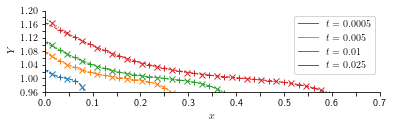

In [21]:
# Pick some time points to plot.
t_arr = np.array([0.0005, 0.005, 0.01, 0.025])
x3 = np.linspace(0,2,8*N+1)

# Set up the plot.
fig = plt.figure(figsize=(6,1.5))
ax = fig.add_subplot(111)
cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Plot for a few different times.
for i in range(len(t_arr)):
    # Find the index for the specified time
    t_index = int(np.round(t_arr[i]/t_step)) # round to avoid floating point errors.
    
    # Find the analytical yield surface. for small B.
    y2 = Y2(x3,t_arr[i])
    y2[y2<0]=0
    
    # Do the plotting.
    ax.plot(x, YS_num[t_index,:], '--' , marker='+', markevery=16, linewidth=1, color=cols[i])
    ax.plot(x3, y2, ':', marker='x', markevery=(64,128), linewidth=1, color=cols[i])
    ax.plot([0,1],[10,10], color=cols[i], linewidth=1, label=r'$t=s1$'.replace('s1',str(t_arr[i])))

    
# Add details to the plot.
ticks1 = np.arange(0,0.75,0.05)
ax.set_xticks(ticks1, labels=np.round(ticks1,1))
ax.set_xlim(0,0.7)
ax.set_xlabel(r'$x$')
xticks = ax.xaxis.get_major_ticks()
for i in range(len(ticks1)):
    xticks[i].label1.set_visible((i+1)%2)

ticks2 = np.arange(0.96,1.22,0.02)
ax.set_yticks(ticks2)
ax.set_ylim(0.96,1.2)
ax.set_ylabel(r'$Y$')
yticks = ax.yaxis.get_major_ticks()
for i in range(len(ticks2)):
    yticks[i].label1.set_visible((i+1)%2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.legend()
#plt.savefig('Bingham_SmallT_YS_NumAn2', bbox_inches='tight', dpi=500)
plt.show()

## Plot the Interface and Yield Surface Together

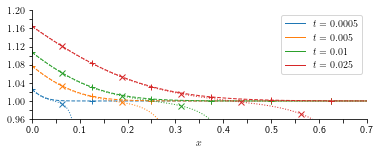

In [22]:
# Pick some time points to plot.
t_arr = np.array([0.0005, 0.005, 0.01, 0.025])
x3 = np.linspace(0,2,8*N+1)

# Set up the plot.
fig = plt.figure(figsize=(6,2))
ax = fig.add_subplot(111)
cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Plot for a few different times.
for i in range(len(t_arr)):
    # Find the index for the specified time
    t_index = int(np.round(t_arr[i]/t_step)) # round to avoid floating point errors.
    
    # Find the analytical yield surface. for small B.
    
    # Do the plotting.
    ax.plot(x, y_num2[t_index,:], '--', linewidth=1, marker='+', markevery=64, color=cols[i])
    ax.plot(x, YS_num[t_index,:], ':', linewidth=1, marker='x', markevery=(32,64), color=cols[i])
    ax.plot([0,1],[10,10], color=cols[i], linewidth=1, label=r'$t=s1$'.replace('s1',str(t_arr[i])))

    
# Add details to the plot.
ticks1 = np.arange(0,0.75,0.05)
ax.set_xticks(ticks1, labels=np.round(ticks1,1))
ax.set_xlim(0,0.7)
ax.set_xlabel(r'$x$')
xticks = ax.xaxis.get_major_ticks()
for i in range(len(ticks1)):
    xticks[i].label1.set_visible((i+1)%2)

ticks2 = np.arange(0.96,1.22,0.02)
ax.set_yticks(ticks2)
ax.set_ylim(0.96,1.2)
yticks = ax.yaxis.get_major_ticks()
for i in range(len(ticks2)):
    yticks[i].label1.set_visible((i+1)%2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.legend()
#plt.savefig('Bingham_SmallT_Both_NumAn2', bbox_inches='tight', dpi=500)
plt.show()